In [1]:
# import all packages used in this notebook
import wandb
from torchvision.ops.focal_loss import sigmoid_focal_loss
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# add importable modules from src to system path for use in this notebook
import os
import sys
src_path = os.path.abspath(os.path.join(".."))
if src_path not in sys.path:
    sys.path.append(src_path)
import src

/users/anddon76/icenet/icenet-gan/notebooks


# Forecast
Let's continue by generating forecasts with trained models in this notebook.

As before, we maintain alignment with the [`icenet-paper` repository](https://github.com/tom-andersson/icenet-paper).

### 1. Construct test dataset
We'll need data to make a forecast. Let's load our held-out test data to evaluate our models' capacity for generalisation.

In [2]:
test_dataset = src.IceNetDataset(f"{src.dataloader_config_folder}/2023_06_24_1235_icenet_gan.json", mode="test")
test_dataset.obs_forecast_IDs

Setting the data generator's random seed to 42
Checking forecast start dates for missing SIC dates... Setting up the variable paths for dataset_no_cmip... Done.
Setting the number of input months for each input variable.
Loading and augmenting the polar holes... Done in 0s.

on_epoch_end called
Setup complete.



[Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2018-08-01 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-11-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-02-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-06-01 00:00:00')]

### 2. Load trained models
We'll also need our trained models to make forecasts.

Our best gan training run is [here](https://wandb.ai/andrewmcdonald/icenet-gan/runs/wq09bzy7/overview?workspace=user-andrewmcdonald) with colloquial name `radiant-sponge-59-great-unet` and hash name `wq09bzy7`.

Our best GAN training run is [here](https://wandb.ai/andrewmcdonald/icenet-gan/runs/4iuiyi32/overview?workspace=user-andrewmcdonald) with colloquial name `stilted-armadillo-99-great-onestep-gan` and hash name `4iuiyi32`.

In [3]:
api = wandb.Api()
unet_name = "wq09bzy7"
unet_run = api.run(f"{src.config.WANDB_USERNAME}/icenet-gan/{unet_name}")
gan_name = "4iuiyi32"
gan_run = api.run(f"{src.config.WANDB_USERNAME}/icenet-gan/{gan_name}")


In [4]:
unet_run.config

{'name': 'default',
 'seed': 42,
 'model': 'unet',
 'devices': 1,
 'criterion': 'focal',
 'n_workers': 8,
 'precision': 16,
 'batch_size': 10,
 'max_epochs': 100,
 'accelerator': 'auto',
 'filter_size': 3,
 'fast_dev_run': False,
 'learning_rate': 0.0001,
 'n_to_visualise': 1,
 'n_filters_factor': 1,
 'dataloader_config': '2023_06_24_1235_icenet_gan.json',
 'limit_val_batches': 1,
 'log_every_n_steps': 10,
 'limit_train_batches': 1,
 'num_sanity_val_steps': 1}

In [5]:
# construct blank model
unet = src.UNet(
    input_channels=test_dataset.tot_num_channels,
    filter_size=unet_run.config["filter_size"],
    n_filters_factor=unet_run.config["n_filters_factor"],
    n_forecast_months=test_dataset.config["n_forecast_months"]
)

# construct criteria
if unet_run.config["criterion"] == "ce":
    criterion = nn.CrossEntropyLoss(reduction="none")
elif unet_run.config["criterion"] == "focal":
    criterion = sigmoid_focal_loss  # reduction="none" by default

# lightning will load checkpointed weights onto this model
unet_best_ckpt = f"{src.config.WANDB_DIR}/dark-dust-102-great-unet/checkpoints/best-epoch=22-step=4347.ckpt"
lit_module_unet = src.LitUNet.load_from_checkpoint(unet_best_ckpt, model=unet, criterion=criterion)
lit_module_unet

LitUNet(
  (model): UNet(
    (conv1a): Conv2d(50, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv1b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv3b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4a): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine

In [6]:
gan_run.config

{'name': 'default',
 'seed': 42,
 'model': 'gan',
 'sigma': 1,
 'devices': 1,
 'criterion': 'focal',
 'n_workers': 8,
 'precision': 16,
 'batch_size': 2,
 'max_epochs': 100,
 'accelerator': 'auto',
 'd_lr_factor': 1,
 'filter_size': 3,
 'fast_dev_run': False,
 'learning_rate': 0.0001,
 'n_to_visualise': 1,
 'generator_lambda': 500,
 'n_filters_factor': 1,
 'dataloader_config': '2023_06_24_1235_icenet_gan.json',
 'limit_val_batches': 1,
 'log_every_n_steps': 10,
 'discriminator_mode': 'onestep',
 'limit_train_batches': 1,
 'num_sanity_val_steps': 1,
 'discriminator_criterion': 'ce',
 'generator_fake_criterion': 'ce',
 'generator_structural_criterion': 'ce'}

In [7]:
# construct blank models
generator = src.Generator(
    input_channels=test_dataset.tot_num_channels,
    filter_size=gan_run.config["filter_size"],
    n_filters_factor=gan_run.config["n_filters_factor"],
    n_forecast_months=test_dataset.config["n_forecast_months"]
)
discriminator = src.Discriminator(
    input_channels=test_dataset.tot_num_channels,
    filter_size=gan_run.config["filter_size"],
    n_filters_factor=gan_run.config["n_filters_factor"],
    n_forecast_months=test_dataset.config["n_forecast_months"],
    mode=gan_run.config["discriminator_mode"]
)

# construct criteria
generator_fake_criterion = nn.BCEWithLogitsLoss(reduction="none")

if gan_run.config["generator_structural_criterion"] == "l1":
    generator_structural_criterion = nn.L1Loss(reduction="none")
elif gan_run.config["generator_structural_criterion"] == "ce":
    generator_structural_criterion = nn.CrossEntropyLoss(reduction="none")
elif gan_run.config["generator_structural_criterion"] == "focal":
    generator_structural_criterion = sigmoid_focal_loss

discriminator_criterion = nn.BCEWithLogitsLoss(reduction="none")

# lightning will load checkpointed weights onto this model
gan_best_ckpt = f"{src.config.WANDB_DIR}/stilted-armadillo-99-great-onestep-gan/checkpoints/best-epoch=7-step=3024-v1.ckpt"
lit_module_gan = src.LitGAN.load_from_checkpoint(
    gan_best_ckpt,
    generator=generator,
    discriminator=discriminator,
    generator_fake_criterion=generator_fake_criterion,
    generator_structural_criterion=generator_structural_criterion,
    discriminator_criterion=discriminator_criterion
)
lit_module_gan

LitGAN(
  (generator): Generator(
    (conv1a): Conv2d(51, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv1b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv3b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4a): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1

### 3. Create forecasts
Let's pass our held-out test data through each trained model and visualise the output tensors.

We'll check our available GPU memory with `!nvidia-smi` and will enable `torch.no_grad()` to save memory since we won't need gradients in this setting.

Note that an inherent advantage of the GAN architecture is that the generator learns an implicit probability distribution of the data when trying to fool the discriminator during training. As such, we can draw samples from the generator at inference-time with no additional training cost. Each forward pass through the generator combines randomly-sampled noise with the conditioning input variables before feeding it through the convolutional, downsampling, and upsampling layers, such that the output of the generator on two consecutive passes over the same data will be slightly different (unless the random number generator is re-seeded). In contrast, when dealing with the UNet architecture, we must train a suite of models, each with a unique random seed, if we wish to obtain a probabilistic forecast at inference-time.

We'll make use of this feature here to generate a 25-member ensemble forecast with our GAN.

Because we've only trained one UNet model, however, we'll generate a deterministic forecast in its case.

In [8]:
test_dataloader_unet = DataLoader(test_dataset, batch_size=unet_run.config["batch_size"], num_workers=8,
                                  persistent_workers=True, pin_memory=False, shuffle=False)
test_dataloader_gan = DataLoader(test_dataset, batch_size=gan_run.config["batch_size"], num_workers=8,
                                  persistent_workers=True, pin_memory=False, shuffle=False)

In [9]:
!nvidia-smi

Tue Jun 27 23:17:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A2           On   | 00000000:98:00.0 Off |                    0 |
|  0%   37C    P0    19W /  60W |   1382MiB / 15356MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We'll start by generating forecasts with our UNet.

In [10]:
# pass batches through unet and accumulate into list
# deterministic forecast
y_hat_unet = []
with torch.no_grad():
    for batch in test_dataloader_unet:
        x, y, sample_weight = batch
        pred_unet = lit_module_unet(x.to(lit_module_unet.device)).detach().cpu().numpy()
        y_hat_unet.extend(pred_unet)
y_hat_unet = np.array(y_hat_unet)
y_hat_unet = np.expand_dims(y_hat_unet, 0)
y_hat_unet.shape  # ensemble member, forecast, h, w, c, timesteps

/users/anddon76/micromamba/envs/icenet-gan/lib/python3.11/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


(1, 17, 432, 432, 3, 6)

We'll continue by generating forecasts with our GAN.

In [11]:
# pass batches through gan and accumulate into list
# probabilistic forecast with 25 ensemble members
y_hat_gan = []
with torch.no_grad():
    for ensemble_member in tqdm(range(src.config.n_ensemble_members)):
        y_hat_member = []
        for batch in test_dataloader_gan:
            x, y, sample_weight = batch
            pred_gan = lit_module_gan(x.to(lit_module_gan.device)).detach().cpu().numpy()
            y_hat_member.extend(pred_gan)
        y_hat_gan.append(y_hat_member)
y_hat_gan = np.array(y_hat_gan)
y_hat_gan.shape

100%|██████████| 25/25 [02:39<00:00,  6.37s/it]


(25, 17, 432, 432, 3, 6)

In [12]:
# compute the mean of gan ensemble forecast
y_hat_gan_mean = np.mean(y_hat_gan, axis=0, keepdims=True)
y_hat_gan_mean.shape

(1, 17, 432, 432, 3, 6)

In [13]:
# append mean to end of ensemble for quick downstream access
y_hat_gan_with_mean = np.concatenate([y_hat_gan, y_hat_gan_mean])
y_hat_gan_with_mean.shape

(26, 17, 432, 432, 3, 6)

In [14]:
torch.cuda.empty_cache()  # free pytorch memory
!nvidia-smi

Tue Jun 27 23:20:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A2           On   | 00000000:98:00.0 Off |                    0 |
|  0%   58C    P0    23W /  60W |    616MiB / 15356MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Finally, let's generate a linear forecast for use as a baseline.

In [15]:
linear_forecast_months = test_dataset.obs_forecast_IDs + [test_dataset.obs_forecast_IDs[-1] + \
                         pd.DateOffset(months=1+lead) for lead in range(test_dataset.config["n_forecast_months"])]
linear_forecast_months  # dates we'll need a linear trend forecast when accounting for leadtimes

[Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2018-08-01 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-11-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-02-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-06-01 00:00:00'),
 Timestamp('2019-07-01 00:00:00'),
 Timestamp('2019-08-01 00:00:00'),
 Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-11-01 00:00:00'),
 Timestamp('2019-12-01 00:00:00')]

In [16]:
y_hat_linear = []
for start_date in tqdm(linear_forecast_months):
    pred, sie = src.models.linear_trend_forecast(start_date, n_linear_years=35)
    y_hat_linear.append(pred)
y_hat_linear = np.array(y_hat_linear)
y_hat_linear.shape

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:04<00:00,  5.74it/s]


(23, 432, 432)

In [17]:
# unroll one-month forecasts to be six-month forecasts for each starting date
y_hat_linear_unrolled = np.zeros((
    1,  # seed dimension
    len(test_dataset.obs_forecast_IDs),  # number of forecasts
    *test_dataset.config["raw_data_shape"],  # h, w
    test_dataset.config["n_forecast_months"],  # leadtimes
))
for start_idx in range(len(test_dataset.obs_forecast_IDs)):
    for leadtime in range(test_dataset.config["n_forecast_months"]):
        y_hat_linear_unrolled[0, start_idx, :, :, leadtime] = y_hat_linear[start_idx + leadtime]

y_hat_linear_unrolled = np.expand_dims(y_hat_linear_unrolled, -1)  # add channel dimension for consistency
y_hat_linear_unrolled.shape

(1, 17, 432, 432, 6, 1)

### 4. Format and save forecasts
Let's save our forecasts as netCDF files before we move to evaluate them in the next notebook.

This will allow us to extend our downstream evaluation methods without needing to load and run our computationally-intensive models each time we want to obtain a forecast.

This will also make our forecasts accessible to others who may be interested in sea ice but not in the technical nuances of deep learning.

In [18]:
# open true sic file for spatial information and reference of what file should look like
true_sic_da = xr.open_dataarray(f"{src.config.obs_data_folder}/siconca_EASE.nc")
true_sic_da

<xarray.DataArray 'ice_conc' (time: 511, yc: 432, xc: 432)>
[95364864 values with dtype=float64]
Coordinates:
  * xc       (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc       (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-07-01
    lat      (yc, xc) float32 ...
    lon      (yc, xc) float32 ...
Attributes:
    long_name:            fully filtered concentration of sea ice using atmos...
    standard_name:        sea_ice_area_fraction
    units:                %
    valid_min:            0
    valid_max:            10000
    grid_mapping:         Lambert_Azimuthal_Grid
    ancillary_variables:  total_standard_error status_flag
    comment:              this field is the primary sea ice concentration est...
    _ChunkSizes:          [  1 432 432]

Let's structure and visualise our GAN forecast first.

In [19]:
# build probabilistic file for gan forecasts
coords = {
    "time": test_dataset.obs_forecast_IDs,
    "yc": true_sic_da.coords["yc"],
    "xc": true_sic_da.coords["xc"],
    "lon": true_sic_da.isel(time=0).coords["lon"],
    "lat": true_sic_da.isel(time=0).coords["lat"],
    "leadtime": list(range(test_dataset.config["n_forecast_months"])),
}

dims = ("seed", "time", "yc", "xc", "leadtime", "ice_class")
coords["seed"] = list(range(src.config.n_ensemble_members)) + ["mean"]
coords["ice_class"] = ["no_ice", "marginal_ice", "full_ice"]

gan_forecast = xr.DataArray(data=y_hat_gan_with_mean.swapaxes(-1, -2), coords=coords, dims=dims)  # swap lead/class dims
gan_forecast

<xarray.DataArray (seed: 26, time: 17, yc: 432, xc: 432, leadtime: 6,
                   ice_class: 3)>
array([[[[[[7.33408511e-01, 2.66590863e-01, 5.82813982e-07],
           [9.76874173e-01, 2.31258739e-02, 7.90252130e-09],
           [9.71473455e-01, 2.85261422e-02, 4.07183506e-07],
           [9.23687935e-01, 7.63112009e-02, 8.35898561e-07],
           [9.97344196e-01, 2.65581021e-03, 1.04643627e-08],
           [6.67439997e-01, 3.32559347e-01, 7.01992406e-07]],

          [[9.92224932e-01, 7.77506828e-03, 2.11593612e-12],
           [9.99859452e-01, 1.40496064e-04, 1.13877375e-15],
           [9.98455286e-01, 1.54465484e-03, 3.69849767e-12],
           [9.94538248e-01, 5.46178967e-03, 7.39087055e-11],
           [9.99982595e-01, 1.74484958e-05, 8.62614118e-17],
           [9.98057544e-01, 1.94238522e-03, 2.22371340e-11]],

          [[9.99054372e-01, 9.45667736e-04, 4.44667649e-15],
           [9.99986410e-01, 1.36480612e-05, 1.01535272e-18],
           [9.99687552e-01, 3.12507065e-04, 8.98870601e-15],
           [9.98875439e-01, 1.12452928e-03, 7.17633093e-13],
           [9.99998569e-01, 1.46525031e-06, 1.28492185e-20],
           [9.99951601e-01, 4.83495132e-05, 1.18264285e-13]],
...
           [6.65185098e-07, 5.73884249e-01, 4.26115125e-01],
           [9.52330902e-06, 8.59907508e-01, 1.40082896e-01],
           [4.09533619e-04, 9.85496700e-01, 1.40937818e-02],
           [1.50188450e-02, 9.84732449e-01, 2.48579920e-04],
           [2.05533445e-01, 7.94413090e-01, 5.34989813e-05]],

          [[1.90198887e-04, 9.85879838e-01, 1.39298812e-02],
           [4.45914266e-05, 6.78740025e-01, 3.21215481e-01],
           [2.35850035e-04, 9.07510757e-01, 9.22534242e-02],
           [8.96660704e-03, 9.66332793e-01, 2.47006249e-02],
           [1.18569277e-01, 8.80455196e-01, 9.75608593e-04],
           [5.25087237e-01, 4.74537700e-01, 3.75096133e-04]],

          [[1.02184527e-02, 9.05244589e-01, 8.45368579e-02],
           [6.14250172e-03, 7.34628916e-01, 2.59228677e-01],
           [8.74352641e-03, 8.57266009e-01, 1.33990571e-01],
           [2.11586952e-01, 6.89247489e-01, 9.91655439e-02],
           [4.37689692e-01, 5.50443709e-01, 1.18665388e-02],
           [7.56041706e-01, 2.33007565e-01, 1.09506855e-02]]]]]],
      dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2018-02-01 2018-03-01 ... 2019-06-01
  * yc         (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
  * xc         (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
    lon        (yc, xc) float32 ...
    lat        (yc, xc) float32 ...
  * leadtime   (leadtime) int64 0 1 2 3 4 5
  * seed       (seed) <U21 '0' '1' '2' '3' '4' ... '21' '22' '23' '24' 'mean'
  * ice_class  (ice_class) <U12 'no_ice' 'marginal_ice' 'full_ice'

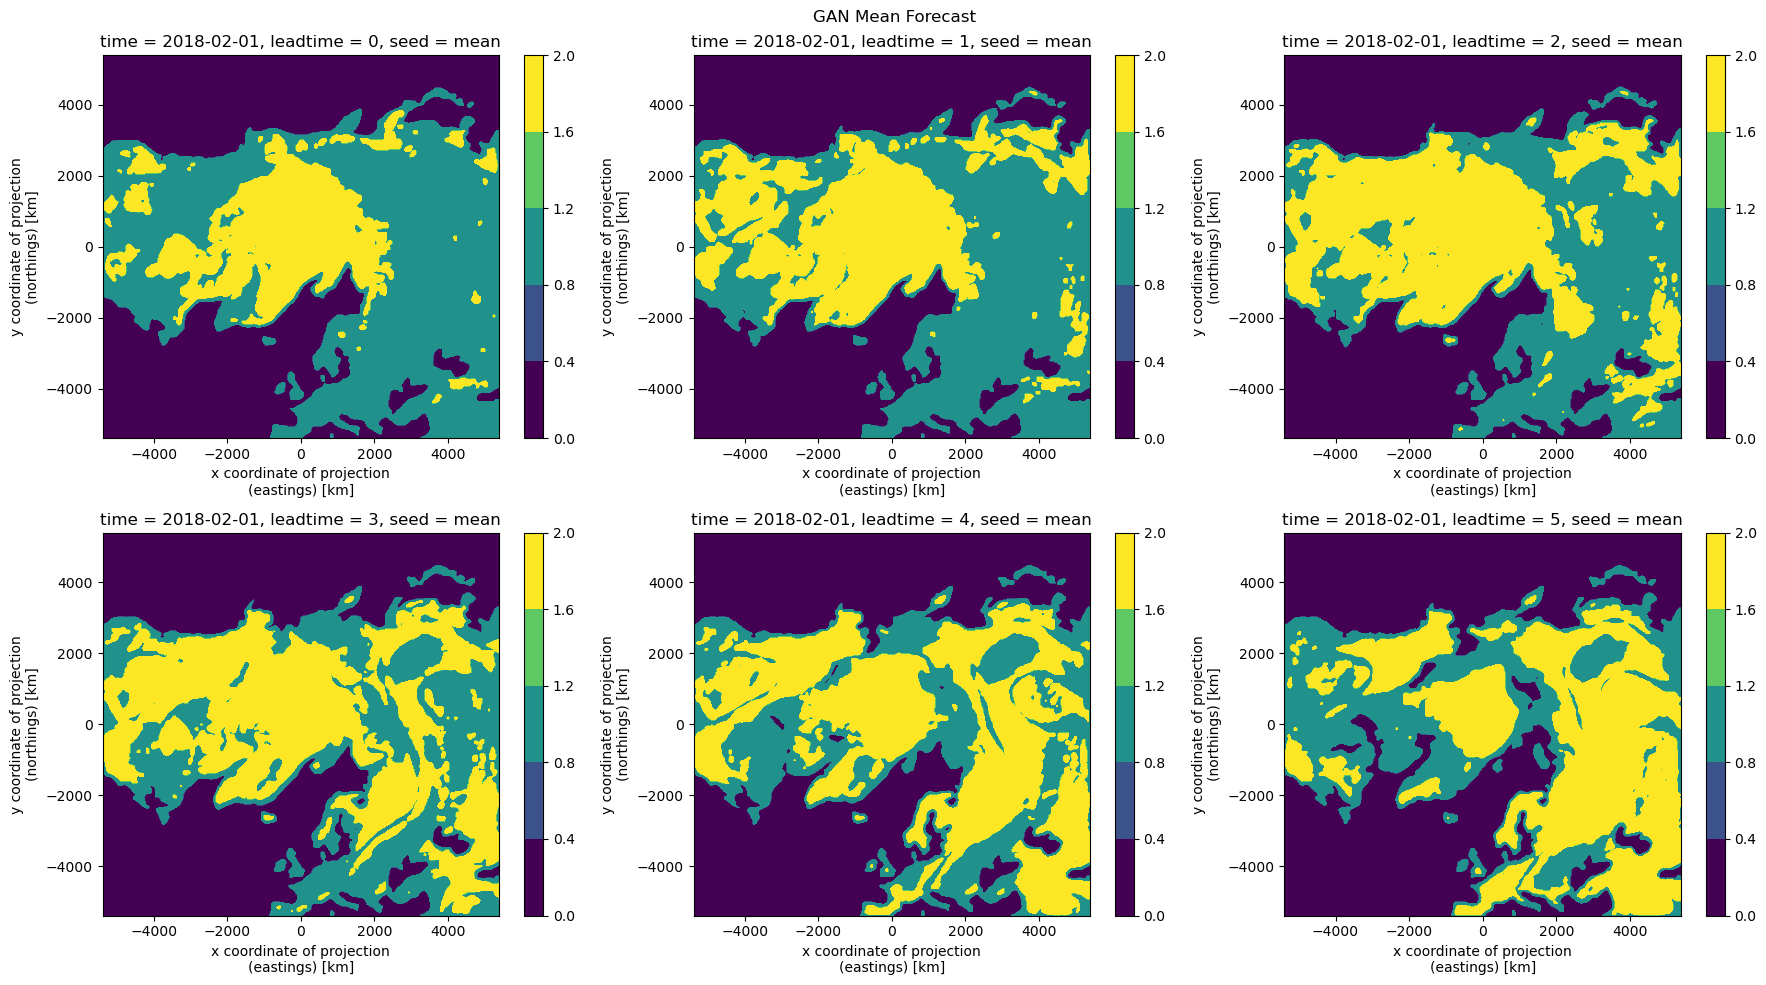

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))
ax = ax.ravel()
for i in range(6):
    # get mean forecast at end (-1) of seed dimension
    xr.plot.contourf(gan_forecast.isel(seed=-1, time=0, leadtime=i).argmax(dim="ice_class"), ax=ax[i])
plt.suptitle("GAN Mean Forecast")
plt.tight_layout()
plt.show()

Brilliant! Now, let's structure and visualise our UNet forecast.

In [21]:
# build deterministic file for unet forecasts
coords["seed"] = ["mean"]
unet_forecast = xr.DataArray(data=y_hat_unet.swapaxes(-1, -2), coords=coords, dims=dims)  # swap lead/class dims
unet_forecast

<xarray.DataArray (seed: 1, time: 17, yc: 432, xc: 432, leadtime: 6,
                   ice_class: 3)>
array([[[[[[5.52408099e-01, 4.36670303e-01, 1.09216496e-02],
           [7.31308281e-01, 2.60554254e-01, 8.13740771e-03],
           [6.47780836e-01, 3.17473501e-01, 3.47456336e-02],
           [4.51879025e-01, 5.09795904e-01, 3.83250751e-02],
           [6.59303188e-01, 3.18042487e-01, 2.26543359e-02],
           [6.02955461e-01, 3.86734128e-01, 1.03104282e-02]],

          [[9.08862889e-01, 9.08586606e-02, 2.78413994e-04],
           [9.56105232e-01, 4.37861606e-02, 1.08584711e-04],
           [8.65021050e-01, 1.31590545e-01, 3.38843069e-03],
           [7.84539580e-01, 2.11368740e-01, 4.09165211e-03],
           [9.10746694e-01, 8.84345770e-02, 8.18714907e-04],
           [9.05204237e-01, 9.40762907e-02, 7.19521719e-04]],

          [[9.77767885e-01, 2.22016666e-02, 3.04609202e-05],
           [9.85898256e-01, 1.40936142e-02, 8.08374989e-06],
           [9.52227473e-01, 4.71731387e-02, 5.99352468e-04],
           [9.46463168e-01, 5.29509708e-02, 5.85936592e-04],
           [9.66399312e-01, 3.34432051e-02, 1.57474511e-04],
           [9.69801545e-01, 2.99933031e-02, 2.05058459e-04]],
...
           [1.32091809e-04, 2.82466441e-01, 7.17401445e-01],
           [2.95564212e-04, 4.10228521e-01, 5.89475930e-01],
           [2.59373989e-03, 6.70452178e-01, 3.26953977e-01],
           [9.52913705e-03, 6.39458358e-01, 3.51012498e-01],
           [2.96737486e-03, 8.93407822e-01, 1.03624769e-01]],

          [[1.42282574e-03, 3.51019204e-01, 6.47557914e-01],
           [5.87169663e-04, 4.06349480e-01, 5.93063354e-01],
           [1.08093722e-03, 5.25033295e-01, 4.73885804e-01],
           [6.37823995e-03, 7.61889219e-01, 2.31732562e-01],
           [2.08215285e-02, 7.12422967e-01, 2.66755521e-01],
           [7.91251194e-03, 8.81155729e-01, 1.10931799e-01]],

          [[1.58386920e-02, 4.26191121e-01, 5.57970166e-01],
           [1.01168668e-02, 5.35658062e-01, 4.54225093e-01],
           [1.32160755e-02, 5.27790308e-01, 4.58993614e-01],
           [4.24736887e-02, 7.05806792e-01, 2.51719624e-01],
           [9.55643207e-02, 5.79755425e-01, 3.24680239e-01],
           [6.60232008e-02, 7.01489806e-01, 2.32486933e-01]]]]]],
      dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2018-02-01 2018-03-01 ... 2019-06-01
  * yc         (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
  * xc         (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
    lon        (yc, xc) float32 ...
    lat        (yc, xc) float32 ...
  * leadtime   (leadtime) int64 0 1 2 3 4 5
  * seed       (seed) <U4 'mean'
  * ice_class  (ice_class) <U12 'no_ice' 'marginal_ice' 'full_ice'

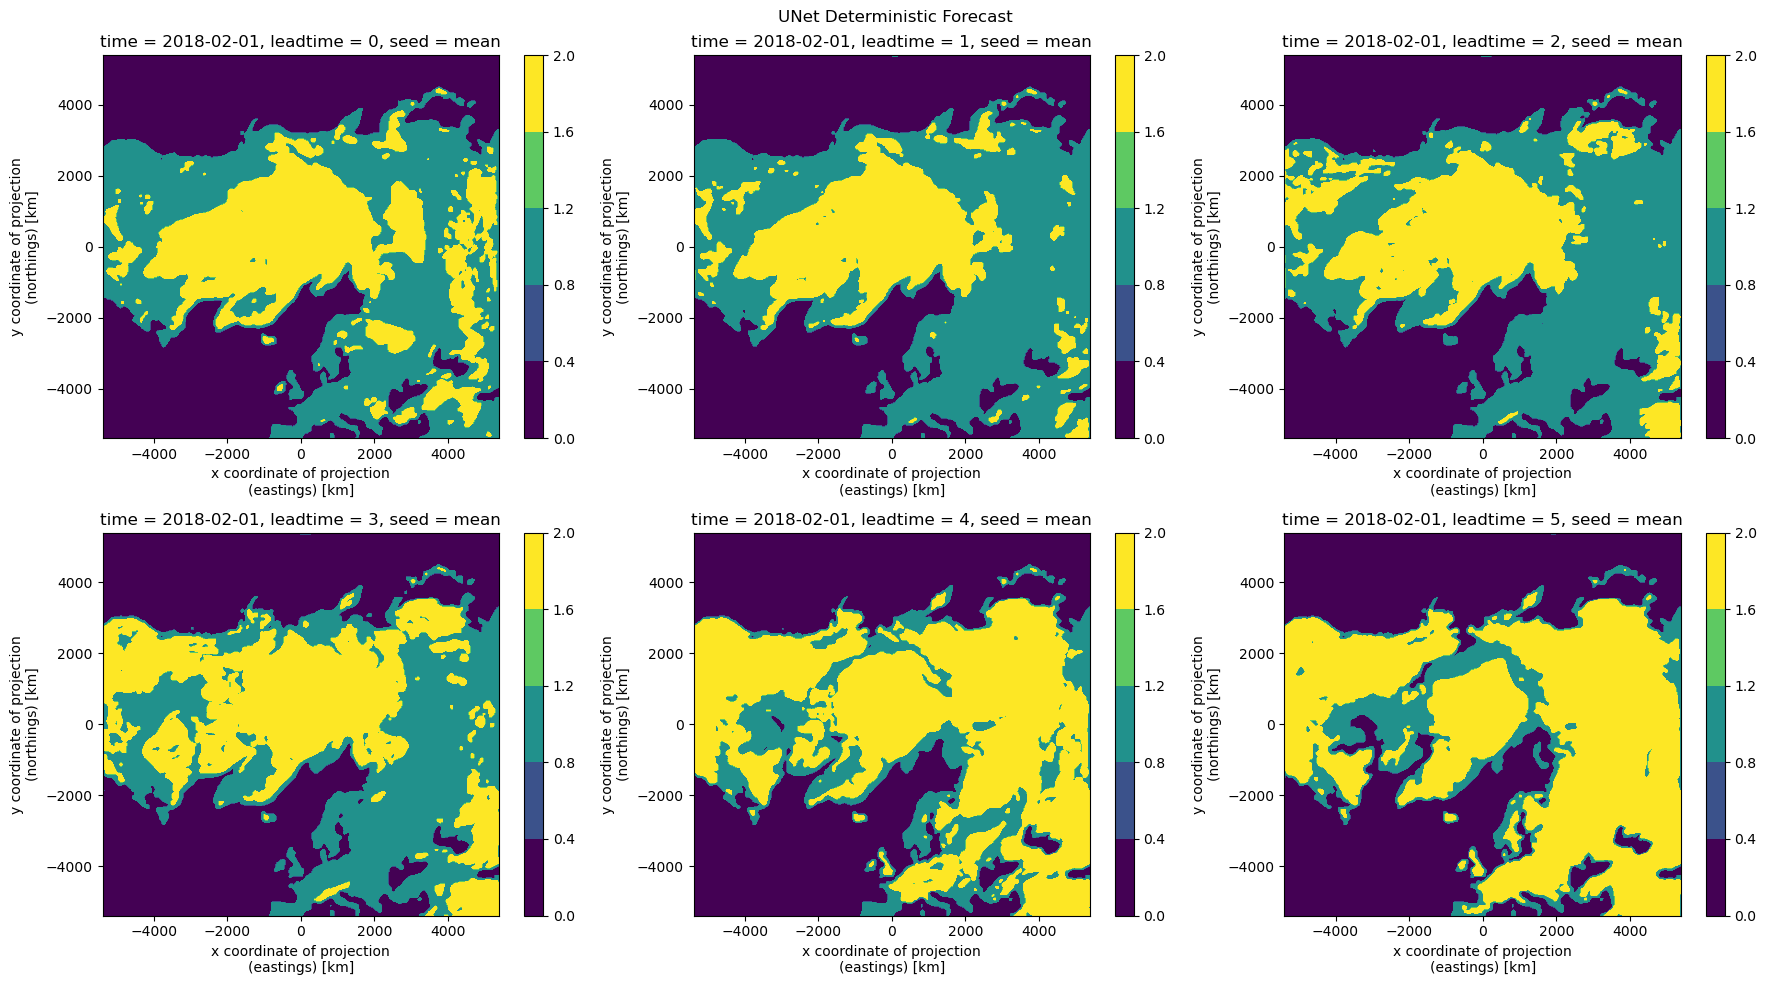

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))
ax = ax.ravel()
for i in range(6):
    # get mean forecast at end (-1) of seed dimension
    xr.plot.contourf(unet_forecast.isel(seed=-1, time=0, leadtime=i).argmax(dim="ice_class"), ax=ax[i])
plt.suptitle("UNet Deterministic Forecast")
plt.tight_layout()
plt.show()

Sweet! Now, let's structure and visualise our linear forecast.

In [23]:
coords["ice_class"] = ["sic"]  # single real-valued channel
linear_forecast = xr.DataArray(data=y_hat_linear_unrolled, coords=coords, dims=dims)
linear_forecast

<xarray.DataArray (seed: 1, time: 17, yc: 432, xc: 432, leadtime: 6,
                   ice_class: 1)>
array([[[[[[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]],

          [[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]],

          [[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]],
...
          [[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]],

          [[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]],

          [[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]]]]]])
Coordinates:
  * time       (time) datetime64[ns] 2018-02-01 2018-03-01 ... 2019-06-01
  * yc         (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
  * xc         (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
    lon        (yc, xc) float32 ...
    lat        (yc, xc) float32 ...
  * leadtime   (leadtime) int64 0 1 2 3 4 5
  * seed       (seed) <U4 'mean'
  * ice_class  (ice_class) <U3 'sic'

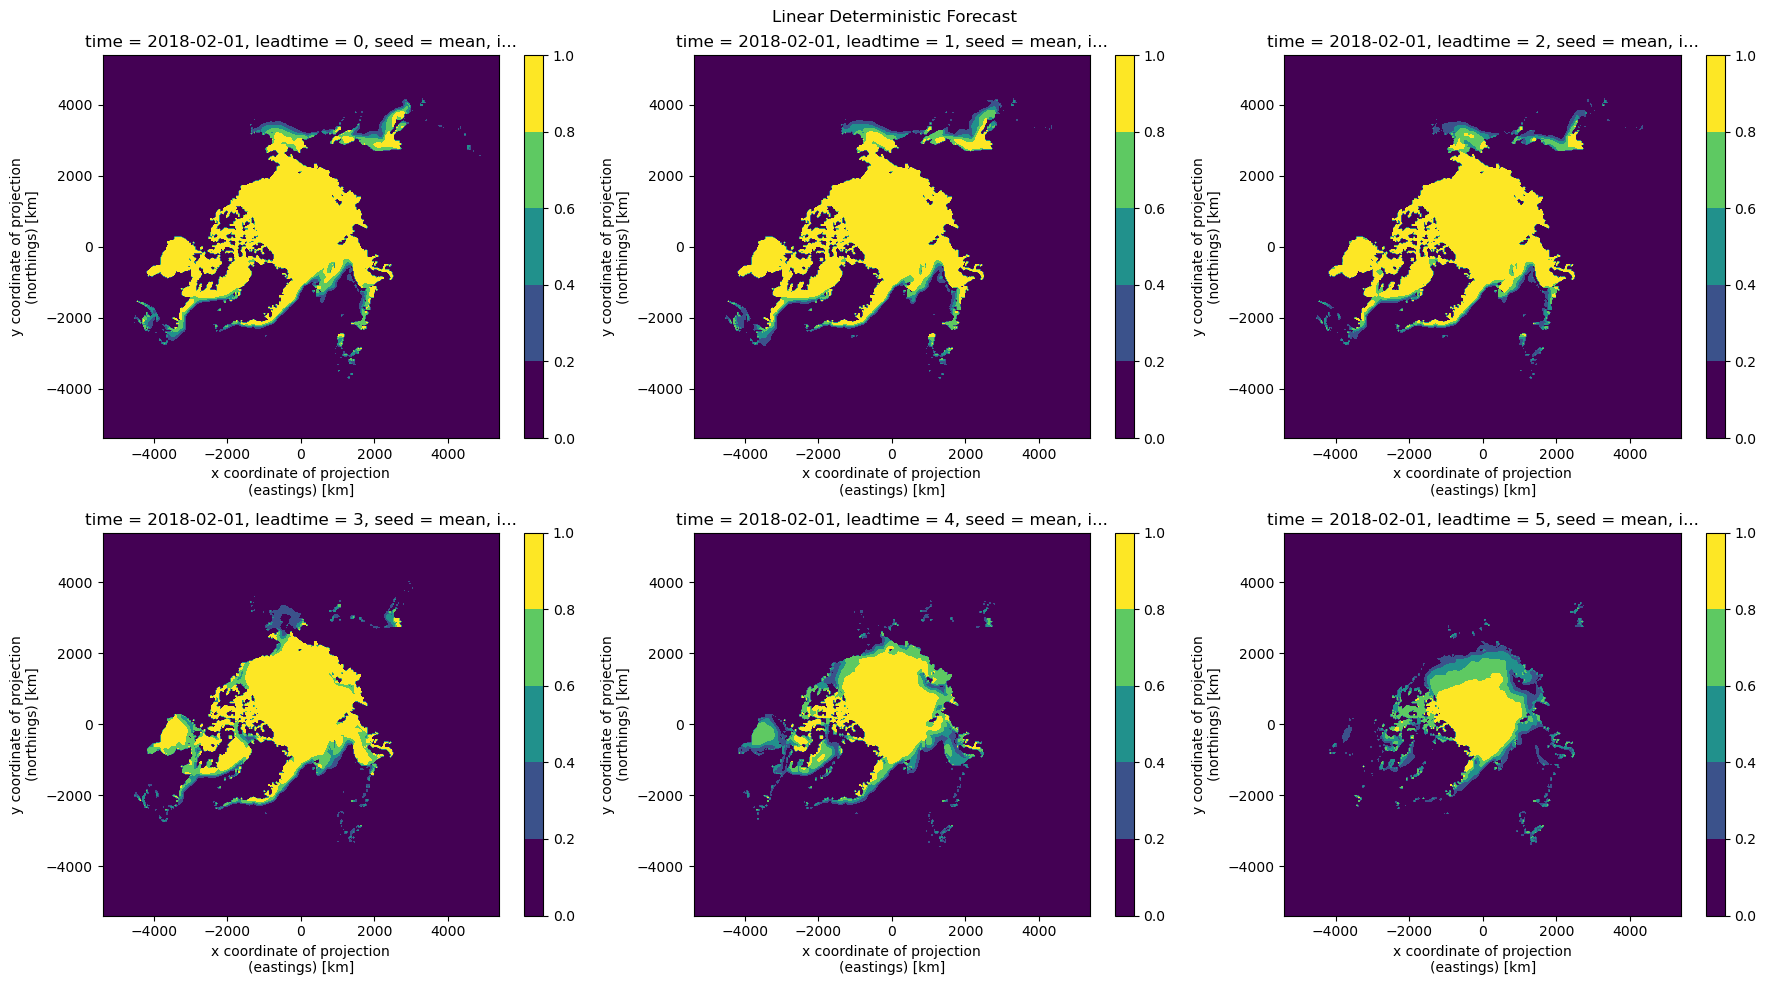

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))
ax = ax.ravel()
for i in range(6):
    # get mean forecast at end (-1) of seed dimension
    xr.plot.contourf(linear_forecast.isel(seed=-1, time=0, leadtime=i, ice_class=0), ax=ax[i])
plt.suptitle("Linear Deterministic Forecast")
plt.tight_layout()
plt.show()

Finally, we can save our forecasts to netCDF files for later evaluation.

In [26]:
gan_forecast_fpath = f"{src.config.forecast_results_folder}/radiant-sponge-59-great-unet.nc"
gan_forecast.to_netcdf(gan_forecast_fpath)
unet_forecast_fpath = f"{src.config.forecast_results_folder}/stilted-armadillo-99-great-onestep-gan.nc"
unet_forecast.to_netcdf(unet_forecast_fpath)
linear_forecast_fpath = f"{src.config.forecast_results_folder}/linear.nc"
linear_forecast.to_netcdf(linear_forecast_fpath)

### 5. All set
With our forecasts safe and sound inside netCDF files, we're clear to move forward.

We'll continue by evaluating these forecasts in the next notebook.